In [ ]:
# Import required libraries and set up Azure OpenAI client using environment variables for security and flexibility
import os
from openai import AzureOpenAI

client = AzureOpenAI(
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY")
)

In [6]:
# Test a simple query completion using the Azure OpenAI client
response = client.chat.completions.create(
    model="o4-mini",
    messages=[
        {"role": "system", "content": "You are an AI assistant that writes SQL queries."},
        {"role": "user", "content": "Write a SQL query to select all users from the users table."}
    ]
)
print(response.choices[0].message.content)

Here’s a simple query to fetch all rows from the users table:

SELECT *
FROM users;


In [ ]:
# Function to evaluate if the LLM output is a correct SQL query for the given input using an LLM prompt
# Returns a JSON with isCorrect, errorType, and errorExplanation fields

def evaluate_sql_generation(input_text, llm_output, client, deployment_name):
    """
    Evaluates if the LLM output is a correct SQL query for the given input using an LLM prompt.
    Returns a JSON with isCorrect, errorType, and errorExplanation fields.
    """
    prompt = (
    "You are an expert SQL evaluator. Your job is to judge whether a SQL query correctly answers a given natural language request.\n\n"
    "You will be given:\n"
    "- A natural language question (user's intent)\n"
    "- A SQL query generated by an LLM\n\n"
    "Your task is to evaluate ONLY whether the SQL query is a correct and complete answer to the question.\n\n"
    "Return your judgment in exactly one of the two following JSON formats:\n"
    '1. If the SQL query is correct and complete:\n'
    '   {"isCorrect": true, "errorType": null, "errorExplanation": null}\n'
    '2. If the SQL query is incorrect:\n'
    '   {"isCorrect": false, "errorType": "<incomplete|irrelevant|logic_error>", "errorExplanation": "<short explanation>"}\n\n'
    "**Return ONLY the JSON object. Do not add any explanation, comments, or formatting.**\n\n"
    f"Natural language question: {input_text}\n"
    f"SQL query: {llm_output}"
)
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[
            {"role": "system", "content": prompt}
        ]
    )
    result = response.choices[0].message.content.strip()
    return result

In [28]:
# Run two example evaluations: one incorrect and one correct, to demonstrate the evaluation function
# The first example should return false, the second should return true
wrong_input = "List all users in the database."
wrong_llm_output = "SELECT name FROM products;"

eval_result_false = evaluate_sql_generation(
    input_text=wrong_input,
    llm_output=wrong_llm_output,
    client=client,
    deployment_name="o4-mini"
)
print("Wrong output result:", eval_result_false)

correct_input = "List all users in the database."
correct_llm_output = "SELECT * FROM users;"

eval_result_true = evaluate_sql_generation(
    input_text=correct_input,
    llm_output=correct_llm_output,
    client=client,
    deployment_name="o4-mini"
)
print("Correct output result:", eval_result_true)

Wrong output result: {"isCorrect": false, "errorType": "irrelevant", "errorExplanation": "Selects from products instead of users table"}
Correct output result: {"isCorrect": true, "errorType": null, "errorExplanation": null}
Correct output result: {"isCorrect": true, "errorType": null, "errorExplanation": null}


In [15]:
# Load the evaluation dataset from HuggingFace Datasets
from datasets import load_dataset

ds = load_dataset("gretelai/synthetic_text_to_sql")
eval_set = ds["test"]

# Print the first 3 items from the evaluation set for inspection
for i, item in enumerate(eval_set):
    print(f"Example {i+1}:")
    print("Prompt:", item["sql_prompt"])
    print("Reference SQL:", item["sql"])
    if i >= 2:
        break

Example 1:
Prompt: What is the average explainability score of creative AI applications in 'Europe' and 'North America' in the 'creative_ai' table?
Reference SQL: SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');
Example 2:
Prompt: Delete all records of rural infrastructure projects in Indonesia that have a completion date before 2010.
Reference SQL: DELETE FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';
Example 3:
Prompt: How many accidents have been recorded for SpaceX and Blue Origin rocket launches?
Reference SQL: SELECT launch_provider, COUNT(*) FROM Accidents GROUP BY launch_provider;


In [29]:
from transformers import pipeline
import torch

# Detect device for best performance (CPU, MPS for Apple Silicon, or CUDA for GPU)
if torch.cuda.is_available():
    device = 0  # CUDA device
elif torch.backends.mps.is_available():
    device = "mps"  # Apple Silicon (M1/M2)
else:
    device = -1  # CPU

# Load the fine-tuned text generation pipeline for SQL generation
generator = pipeline(
    "text-generation",
    model="thiborose/SmolLM2-FT-SQL",
    device=device,
)

Device set to use mps


In [ ]:
def generate_sql_with_pipeline(prompt, generator):
    # Generate SQL using the HuggingFace pipeline with the given prompt
    output = generator(
        [{"role": "user", "content": prompt}],
        max_new_tokens=128,
        return_full_text=False,
    )[0]
    return output["generated_text"].strip()


def evaluate_eval_set_with_pipeline(eval_set, generator, client, deployment_name, max_examples=5):
    # Evaluate the SQL generation pipeline on the evaluation set and collect results
    results = []
    for i, item in enumerate(eval_set):
        prompt = item["sql_prompt"]
        generated_sql = generate_sql_with_pipeline(prompt, generator)
        eval_result = evaluate_sql_generation(
            input_text=prompt,
            llm_output=generated_sql,
            client=client,
            deployment_name=deployment_name
        )
        results.append({
            "prompt": prompt,
            "generated_sql": generated_sql,
            "reference_sql": item["sql"],
            "evaluation": eval_result
        })
        # Print progress for each example
        print(f"Example {i+1} | Prompt: {prompt}\nGenerated SQL: {generated_sql}\nReference SQL: {item['sql']}\nEvaluation: {eval_result}\n---")
        if i + 1 >= max_examples:
            break
    return results


In [31]:
# Run a quick test with the first 5 examples from the evaluation set
pipeline_results = evaluate_eval_set_with_pipeline(eval_set, generator, client, deployment_name="o4-mini", max_examples=5)

Example 1 | Prompt: What is the average explainability score of creative AI applications in 'Europe' and 'North America' in the 'creative_ai' table?
Generated SQL: SELECT AVG(scoring) FROM creative_ai WHERE country IN ('Europe', 'North America') AND app_type = 'Creative AI' AND app_name IN ('AI Chatbot', 'AI Recommendation Engine', 'AI Chatbot Language Translation', 'AI Chatbot Text Summarization', 'AI Support Vector Machine');
Reference SQL: SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');
Evaluation: {"isCorrect": false, "errorType": "logic_error", "errorExplanation": "The query unnecessarily filters by specific app_name and app_type and does not compute separate averages for each region"}
---
Example 2 | Prompt: Delete all records of rural infrastructure projects in Indonesia that have a completion date before 2010.
Generated SQL: DELETE FROM infrastructure_projects WHERE country = 'Indonesia' AND completion_date < 2010;
Reference SQL: D

In [33]:
# Evaluate the pipeline on the entire evaluation set
pipeline_results_full = evaluate_eval_set_with_pipeline(eval_set, generator, client, deployment_name="o4-mini", max_examples=len(eval_set))

Example 1 | Prompt: What is the average explainability score of creative AI applications in 'Europe' and 'North America' in the 'creative_ai' table?
Generated SQL: SELECT AVG(explainability_score) FROM creative_ai WHERE region = 'Europe' AND region = 'North America'
Reference SQL: SELECT AVG(explainability_score) FROM creative_ai WHERE region IN ('Europe', 'North America');
Evaluation: {"isCorrect":false,"errorType":"logic_error","errorExplanation":"Filtering on region uses AND instead of OR or IN, resulting in no rows returned"}
---
Example 2 | Prompt: Delete all records of rural infrastructure projects in Indonesia that have a completion date before 2010.
Generated SQL: DELETE FROM infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';
Reference SQL: DELETE FROM rural_infrastructure WHERE country = 'Indonesia' AND completion_date < '2010-01-01';
Evaluation: {"isCorrect": false, "errorType": "incomplete", "errorExplanation": "Missing filter for rural infrastruc

KeyboardInterrupt: 

### ⚠️⚠️⚠️⚠️

I had to stop the evaluation after around 2k samples because this was taking too long. And 2k is big enough for a fair evaluation. 
Unfortunately, I started the evaluation without setting up checkpoint-saves. So I will save the processed data by manuall copy pasting the output of the previous cell into a file `2.1_llm_eval_output.txt`, and by parsing this file into a dictionary. 

In [54]:
import json
import re

def parse_entries(text):
    # Parse the output text into structured data entries
    entries = text.strip().split('---')
    parsed_data = []
    seen_prompts = set()  # Track prompts already seen to avoid duplicates

    for entry in entries:
        if not entry.strip():
            continue

        example_match = re.search(
            r'Example\s+(\d+)\s+\|\s+Prompt:\s+(.*?)\nGenerated SQL:\s+(.*?)\nReference SQL:\s+(.*?)\nEvaluation:\s+({.*})',
            entry, re.DOTALL)
        if example_match:
            example_id = int(example_match.group(1))
            prompt = example_match.group(2).strip()

            # Ignore if prompt already seen (there are duplicates in the file)
            if prompt in seen_prompts:
                continue
            seen_prompts.add(prompt)

            generated_sql = example_match.group(3).strip()
            reference_sql = example_match.group(4).strip()
            evaluation_json = json.loads(example_match.group(5).strip())

            parsed_data.append({
                "example_id": example_id,
                "prompt": prompt,
                "generated_sql": generated_sql,
                "reference_sql": reference_sql,
                "evaluation": evaluation_json
            })

    return parsed_data

# Read the output file and parse the entries
with open("2.1_llm_eval_output.txt", "r") as infile:
    input_text = infile.read()

data = parse_entries(input_text)

# Save the parsed data to a JSON file
with open("2.2_parsed_output.json", "w") as f:
    json.dump(data, f, indent=2)

print(len(data), "examples parsed from the output file.")

2074 examples parsed from the output file.


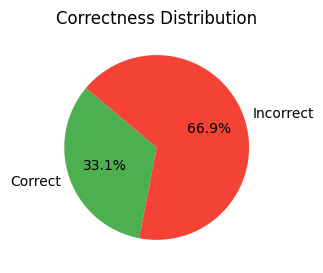

Correct: 686, Incorrect: 1388


In [55]:
import matplotlib.pyplot as plt

# Count correctness
correct = sum(1 for item in data if item.get('evaluation', {}).get('isCorrect') == True)
incorrect = sum(1 for item in data if item.get('evaluation', {}).get('isCorrect') == False)

labels = ['Correct', 'Incorrect']
sizes = [correct, incorrect]
colors = ['#4CAF50', '#F44336']

# Plot a pie chart of correctness distribution
plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Correctness Distribution')
plt.show()

print(f"Correct: {correct}, Incorrect: {incorrect}")

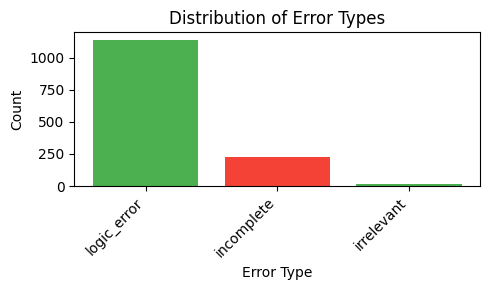

Error Types Distribution:
logic_error: 1142
incomplete: 227
irrelevant: 19


In [56]:
from collections import Counter

# Collect error types from incorrect items
error_types = [
    item['evaluation'].get('errorType', 'unknown')
    for item in data
    if item.get('evaluation', {}).get('isCorrect') == False
]

error_counts = Counter(error_types)
error_labels = list(error_counts.keys())
error_sizes = list(error_counts.values())

plt.figure(figsize=(5, 3))
plt.bar(error_labels, error_sizes, color=colors)
plt.xlabel('Error Type')
plt.ylabel('Count')
plt.title('Distribution of Error Types')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Error Types Distribution:")
for error_type, count in error_counts.items():
    print(f"{error_type}: {count}")


In [47]:
# Display random examples of each error type for qualitative analysis
import random

def print_error_examples(data, error_type, num_samples=5):
    """
    Print examples of items with a specific error type.
    """
    filtered_items = [
        item for item in data
        if item.get('evaluation', {}).get('errorType') == error_type
    ]
    
    sampled_items = random.sample(filtered_items, min(num_samples, len(filtered_items)))
    
    for i, item in enumerate(sampled_items, 1):
        print(f"Sample {i}:")
        print("Prompt:", item.get('prompt'))
        print("Generated SQL:", item.get('generated_sql'))
        print("Reference SQL:", item.get('reference_sql'))
        print("GPT Explanation:", item.get('evaluation', {}).get('errorExplanation'))
        print('-' * 60)

# Print examples of each error type
for error_type in error_counts.keys():
    print(f"Error Type: {error_type}")
    print_error_examples(data, error_type, num_samples=3)
    print("\n" + "=" * 80 + "\n")

Error Type: logic_error
Sample 1:
Prompt: What is the average timber volume for each country in tropical rainforests over the last 3 years?
Generated SQL: SELECT country, AVG(volume) as avg_volume FROM (SELECT country, volume, ROW_NUMBER() OVER (ORDER BY volume DESC) as rn FROM timber_volume WHERE year >= 2019 GROUP BY country, volume) AS subquery GROUP BY country;
Reference SQL: SELECT country, region, AVG(volume) as avg_volume FROM country_timber WHERE region = 'Tropical' AND year BETWEEN 2019 AND 2021 GROUP BY country, region;
GPT Explanation: Missing filter for tropical rainforests and incorrect use of ROW_NUMBER and GROUP BY volume
------------------------------------------------------------
Sample 2:
Prompt: Which community health workers have served the most patients from underrepresented communities in the last year?
Generated SQL: SELECT name FROM community_health_workers WHERE last_service_date >= DATEADD(year, -1, GETDATE()) AND community_population_under_representation > 0;

## 2nd Metric - Syntactic Correctness

In [49]:
import sqlglot

def check_sql_syntax(sql):
    # Check if the given SQL query is syntactically correct using sqlglot
    try:
        sqlglot.parse_one(sql)
        return True, None
    except (sqlglot.errors.ParseError, sqlglot.errors.TokenError) as e:
        return False, str(e)

# Example usage of the syntax checker
query = "SELECT * FROM table WHERE id = 1"
valid, error = check_sql_syntax(query)
print(valid, error)

True None


In [50]:
# Count how many generated_sql queries are syntactically correct
num_correct = 0
for sample in data:
    valid, _ = check_sql_syntax(sample['generated_sql'])
    if valid:
        num_correct += 1

print(f"Syntactically correct samples: {num_correct} / {len(data)}")

Syntactically correct samples: 2021 / 2074


In [53]:
import random

def print_syntax_error_examples(data, num_samples = 5) -> None:
    """
    Print examples of items with syntax errors in the generated SQL.
    """
    syntax_error_items = []
    
    for item in data:
        is_valid, error_msg = check_sql_syntax(item['generated_sql'])
        if not is_valid:
            syntax_error_items.append({
                "prompt": item.get('prompt'),
                "generated_sql": item.get('generated_sql'),
                "error_msg": error_msg
            })

    if not syntax_error_items:
        print("No syntactically incorrect SQL queries found.")
        return

    sampled_items = random.sample(syntax_error_items, min(num_samples, len(syntax_error_items)))

    for i, item in enumerate(sampled_items, 1):
        print(f"Sample {i}:")
        print(f"Prompt: {item['prompt']}")
        print(f"Generated SQL: {item['generated_sql']}")
        print(f"Syntax Error: {item['error_msg']}")
        print('-' * 60)

# Print examples of syntax errors in generated SQL
print("Syntactically incorrect SQL examples:")
print_syntax_error_examples(data, num_samples=5)

Syntactically incorrect SQL examples:
Sample 1:
Prompt: What is the total number of multimodal trips taken in Toronto, Canada using public transportation?
Generated SQL: SELECT SUM(trips.trip_count) FROM trips JOIN trips.trips ON trips.trip_id = trips.trip_id JOIN trips.trips ON trips.trips_id = trips.trips_id JOIN trips.trips ON trips.trips_id = trips.trips_id JOIN trips.trips ON trips.trips_id = trips.trips_id JOIN trips.trips ON trips.trips_id = trips.trips_id WHERE trips.city = 'Toronto' AND trips.trips_type =
Syntax Error: Required keyword: 'expression' missing for <class 'sqlglot.expressions.EQ'>. Line 1, Col: 349.
  IN trips.trips ON trips.trips_id = trips.trips_id WHERE trips.city = 'Toronto' AND trips.trips_type =
------------------------------------------------------------
Sample 2:
Prompt: Find the top 5 autonomous vehicles with the lowest price increase per mile compared to their first model year
Generated SQL: SELECT AVG(Price / (SELECT COUNT(*) FROM VEhicles WHERE Model =